### Imports

In [16]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from datasets import Dataset as HFDataset, DatasetDict
from transformers import (
    PretrainedConfig,
    PreTrainedModel,
    Trainer,
    TrainingArguments,
)
from transformers.modeling_outputs import MaskedLMOutput
from typing import Optional, Union, Dict, Any, List
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import EarlyStoppingCallback
import random

### Configuration

In [2]:
DATA_PATH = "/content/Masked_morse_code_dataset.csv"
OUTPUT_DIR = "./morse_mlm_out"
MAX_LEN = 128
EMBED_DIM = 256
NUM_HEADS = 8
HIDDEN_DIM = 512
NUM_LAYERS = 4
DROPOUT = 0.1
BATCH_SIZE = 32
NUM_EPOCHS = 50
LR = 3e-4
MASK_PROB = 0.15
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Load Dataset and Intialize Custom Tokenizer

In [3]:
df = pd.read_csv(DATA_PATH).dropna(subset=["morse_masked_sentences", "labels"])
# build token set
tokens = set()
for sent in df["morse_masked_sentences"]:
    tokens.update(sent.split())
# ensure [MASK] and PAD
tokens.add("[MASK]")
tokens.add("[PAD]")
token2id = {tok: i for i, tok in enumerate(sorted(tokens))}
id2token = {i: t for t, i in token2id.items()}
VOCAB_SIZE = len(token2id)

### Align lables and introduce multiple [MASK] tokens for faster training

In [4]:
class MultiMaskMorseDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        token2id: Dict[str,int],
        max_len: int,
        mask_prob: float = 0.15,
    ):
        self.sents     = data["morse_masked_sentences"].tolist()
        self.labels    = data["labels"].tolist()
        self.t2i       = token2id
        self.max_len   = max_len
        self.mask_prob = mask_prob
        self.pad_id    = token2id["[PAD]"]
        self.mask_id   = token2id["[MASK]"]

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, idx):
        # 1) split & restore the one true token
        toks     = self.sents[idx].split()
        mask_pos = toks.index("[MASK]")
        orig_tok = toks.copy()
        orig_tok[mask_pos] = self.labels[idx]

        # 2) truncate or pad the token list to exactly max_len
        if len(orig_tok) >= self.max_len:
            orig_tok = orig_tok[: self.max_len]
        # else we’ll pad after masking

        seq_len   = len(orig_tok)
        orig_ids  = [ self.t2i.get(t, self.pad_id) for t in orig_tok ]

        # 3) pick mask positions (include original, plus random others)
        n_to_mask   = max(1, int(seq_len * self.mask_prob))
        other_idxs  = [i for i in range(seq_len) if i != mask_pos]
        extra_masks = random.sample(other_idxs, n_to_mask - 1)
        mask_idxs   = extra_masks + [min(mask_pos, seq_len - 1)]

        # 4) prepare input_ids & labels (init all -100)
        input_ids     = orig_ids.copy()
        labels       = [-100] * self.max_len
        for m in mask_idxs:
            labels[m]     = orig_ids[m]
            input_ids[m]  = self.mask_id

        # 5) pad input_ids & attention_mask to max_len
        attention_mask = [1] * seq_len
        if seq_len < self.max_len:
            pad_len = self.max_len - seq_len
            input_ids     += [self.pad_id]    * pad_len
            attention_mask+= [0]              * pad_len
            # labels already has length max_len
        else:
            attention_mask = attention_mask[: self.max_len]

        return {
            "input_ids":      torch.tensor(input_ids,      dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels":         torch.tensor(labels,         dtype=torch.long),
        }

### Split data in train and val datasets

In [5]:
# split train/val
train_df = df.sample(frac=0.8)
val_df = df.drop(train_df.index)
train_ds = MultiMaskMorseDataset(train_df, token2id, MAX_LEN, mask_prob=0.15)
val_ds   = MultiMaskMorseDataset(val_df,   token2id, MAX_LEN, mask_prob=0.15)

### Model Definition

In [6]:
# 4) MODEL DEFINITION
class MorseConfig(PretrainedConfig):
    model_type = "morse-transformer"
    def __init__(
        self,
        vocab_size: int = VOCAB_SIZE,
        hidden_size: int = EMBED_DIM,
        num_hidden_layers: int = NUM_LAYERS,
        num_attention_heads: int = NUM_HEADS,
        intermediate_size: int = HIDDEN_DIM,
        max_position_embeddings: int = MAX_LEN,
        dropout: float = DROPOUT,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.max_position_embeddings = max_position_embeddings
        self.dropout = dropout

class MorseForMaskedLM(PreTrainedModel):
    config_class = MorseConfig

    def __init__(self, config: MorseConfig):
        super().__init__(config)
        self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.hidden_size,
            nhead=config.num_attention_heads,
            dim_feedforward=config.intermediate_size,
            dropout=config.dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, config.num_hidden_layers)
        self.dropout = nn.Dropout(config.dropout)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size)

        # initialize weights
        self.init_weights()

    def forward(
        self,
        input_ids: torch.LongTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        labels: Optional[torch.LongTensor] = None,
    ) -> Union[MaskedLMOutput, tuple]:
        bsz, seq_len = input_ids.size()

        # embeddings + positions
        pos_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(bsz, -1)
        x = self.token_embeddings(input_ids) + self.position_embeddings(pos_ids)
        x = self.dropout(x)

        # transformer encoder
        # key_padding_mask expects True for tokens to mask
        pad_mask = attention_mask == 0 if attention_mask is not None else None
        x = self.encoder(x, src_key_padding_mask=pad_mask)

        logits = self.lm_head(x)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, self.config.vocab_size), labels.view(-1))

        return MaskedLMOutput(loss=loss, logits=logits)

### Training Arguments

In [7]:
config = MorseConfig()
model = MorseForMaskedLM(config).to(DEVICE)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # flatten predictions & labels
    preds = np.argmax(logits, axis=-1).flatten()
    labels = labels.flatten()
    # ignore all the -100s in the labels
    mask = labels != -100
    return {
        "accuracy": accuracy_score(labels[mask], preds[mask])
    }

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LR,
    warmup_steps=200,
    lr_scheduler_type="linear",
    weight_decay=0.01,
    logging_strategy="epoch",
    push_to_hub=False,
    load_best_model_at_end=True,
    greater_is_better=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

### Execute Training

In [8]:
train_result = trainer.train()
eval_result  = trainer.evaluate()
trainer.save_model(OUTPUT_DIR)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nishant1695 (boston_univ) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,3.058100,2.948344,0.178369
2,2.859900,2.641308,0.249257
3,2.472700,2.175329,0.354407
4,2.126300,1.848162,0.437157
5,1.885600,1.660711,0.490811
6,1.718900,1.520501,0.529093
7,1.599000,1.429512,0.553295
8,1.521100,1.358371,0.575709
9,1.452800,1.298112,0.590642
10,1.397700,1.232235,0.613945


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


### Consolidating data for the graphs

In [13]:
df_logs = pd.DataFrame(trainer.state.log_history)
# 5a) First train‐loss entry at each epoch
train_loss = (
    df_logs[df_logs["loss"].notna()]
      .groupby("epoch")["loss"]
      .mean()
)

# 5b) Validation loss & accuracy at each epoch
eval_df     = df_logs[df_logs["eval_loss"].notna()].set_index("epoch")
val_loss     = eval_df["eval_loss"]
val_accuracy = eval_df["eval_accuracy"]

### Plot the Graphs

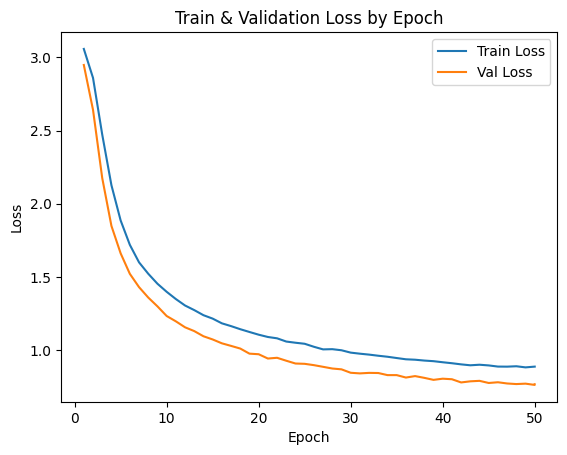

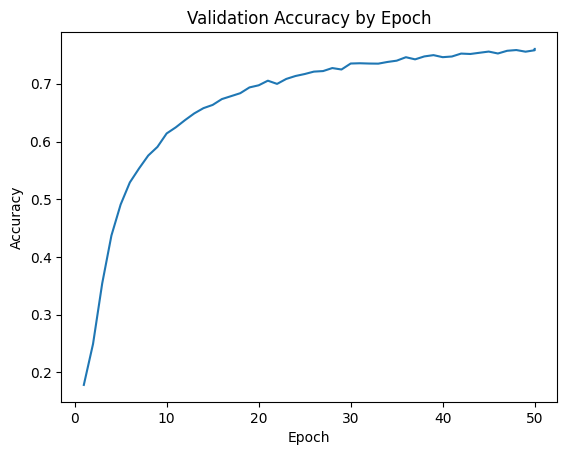

In [14]:
import matplotlib.pyplot as plt

# Loss vs Epoch
plt.figure()
plt.plot(train_loss.index,train_loss.values,label="Train Loss")
plt.plot(val_loss.index,val_loss.values,label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train & Validation Loss by Epoch")
plt.show()

# Accuracy vs Epoch
plt.figure()
plt.plot(val_accuracy.index,val_accuracy.values,label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy by Epoch")
plt.show()

### Inference

In [17]:
def predict_mask_tokens(
    model: MorseForMaskedLM,
    sentence: str,
    token2id: Dict[str,int],
    id2token: Dict[int,str],
    max_len: int = MAX_LEN,
    device: str = DEVICE,
) -> Union[str, List[str]]:
    """
    Returns only the predicted token(s) for each [MASK] in the input.
    If there’s exactly one mask, returns a single string; otherwise a list.
    """
    # 1) tokenize & find mask positions
    toks = sentence.split()
    mask_positions = [i for i,t in enumerate(toks) if t == "[MASK]"]
    assert mask_positions, "No [MASK] in your sentence!"

    # 2) convert to IDs & pad/truncate
    input_ids = [ token2id.get(t, token2id["[PAD]"]) for t in toks ][:max_len]
    seq_len   = len(input_ids)
    attention_mask = [1]*seq_len
    if seq_len < max_len:
        pad_len = max_len - seq_len
        input_ids      += [token2id["[PAD]"]]*pad_len
        attention_mask += [0]*pad_len

    # 3) make tensors
    ids_tensor  = torch.tensor([input_ids],      dtype=torch.long, device=device)
    mask_tensor = torch.tensor([attention_mask], dtype=torch.long, device=device)

    # 4) forward pass
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=ids_tensor, attention_mask=mask_tensor)
        logits  = outputs.logits  # (1, max_len, vocab_size)

    # 5) pick top prediction at each masked position
    pred_ids = logits[0, mask_positions].argmax(dim=-1).cpu().tolist()
    pred_tokens = [id2token[i] for i in pred_ids]

    # 6) if only one mask, return a single string
    return pred_tokens[0] if len(pred_tokens) == 1 else pred_tokens

### Load the best model and test

In [21]:
# load your best model (if you saved it to OUTPUT_DIR)
model = MorseForMaskedLM.from_pretrained(OUTPUT_DIR, config=config).to(DEVICE)

# build reverse vocab
id2token = {i:t for t,i in token2id.items()}

# example
test_sent = "--- ..- .-. / [MASK] / -.-. --- -.. . / - .-. .- -. ... .-.. .- - --- .-. / [.... . .-.. .--. ...] / -.-- --- ..- / - .-. .- -. ... .-.. .- - . / - . -..- - / - --- / -- --- .-. ... . / -.-. --- -.. . / .-... / -- --- .-. ..."
prediction = predict_mask_tokens(model, test_sent, token2id, id2token)
print("Input:     ", test_sent)
print("Prediction:", prediction)

Input:      --- ..- .-. / [MASK] / -.-. --- -.. . / - .-. .- -. ... .-.. .- - --- .-. / [.... . .-.. .--. ...] / -.-- --- ..- / - .-. .- -. ... .-.. .- - . / - . -..- - / - --- / -- --- .-. ... . / -.-. --- -.. . / .-... / -- --- .-. ...
Prediction: .-
